In [21]:
#https://www.tensorflow.org/decision_forests/tutorials/automatic_tuning_colab

from google.cloud import bigquery
from datetime import date, timedelta, datetime 

import pandas as pd
import numpy as np

import math
import os

import tensorflow as tf
print(tf.__version__)

2.12.0


In [22]:
#pip install tensorflow_decision_forests --upgrade --user
import tensorflow_decision_forests as tfdf
print(tfdf.__version__)

1.4.0


# Variable to Configuration

In [23]:
model_tree_type=1# 1= xgboost  2-random forest
option_cate_feature=2

#labelCol='label_multi_severity'
labelCol='label_binary_severity'

In [24]:
projectId='pongthorn'
dataset_id='SMartML'

train_name='train2_incident'
test_name='test2_incident'

train_table_id=f"{projectId}.{dataset_id}.{train_name}"
test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"
print(f"train-ds = {train_table_id}")
print(f"test-ds = {test_tabel_id}")

train-ds = pongthorn.SMartML.train2_incident
test-ds = pongthorn.SMartML.test2_incident


In [25]:
metric="accuracy"
if  labelCol=='label_multi_severity':
    if model_tree_type==1:
        _model='tuned_xgb_tf_model'
    else:
         _model='tuned_rf_tf_model'
else:
    if model_tree_type==1:
        _model='tuned_binary_xgb_tf_model'
    else:
         _model='tuned_binary__rf_tf_model'

model_gs_path=f"gs://demo-tf-incident-pongthorn/{_model}"
print(model_gs_path)

gs://demo-tuned-tf-incident-pongthorn/tuned_binary_xgb_tf_model


In [26]:
if option_cate_feature==1:
    # cateCols=['sla','product_type','brand','service_type','incident_type','range_open_to_close_hour','range_response_to_resolved_hour']
    cateCols=['sla','product_type','brand','service_type','incident_type','range_open_to_close_hour']
    numbericCols=[]
    #unusedCols=['id','severity_id','severity_name','label_binary_severity','open_to_close_hour','response_to_resolved_hour']
    if labelCol=='label_multi_severity':
     unusedCols=['id','severity_id','severity_name','open_to_close_hour','label_binary_severity']
    else:
     unusedCols=['id','severity_id','severity_name','open_to_close_hour','label_multi_severity']   
else:
    cateCols=['sla','product_type','brand','service_type','incident_type']
    numbericCols=['open_to_close_hour']
    if labelCol=='label_multi_severity':
     unusedCols=['id','severity_id','severity_name','range_open_to_close_hour','label_binary_severity']
    else:
      unusedCols=['id','severity_id','severity_name','range_open_to_close_hour','label_multi_severity']  


print(f"CateCols : {cateCols}")
print(f"NumbericCols : {numbericCols}")
print(f"UnusedCols : {unusedCols}")

CateCols : ['sla', 'product_type', 'brand', 'service_type', 'incident_type']
NumbericCols : ['open_to_close_hour']
UnusedCols : ['id', 'severity_id', 'severity_name', 'range_open_to_close_hour', 'label_multi_severity']


# Load & Prepare Data

In [27]:
def load_ml_data(data_path):
 df=pd.read_csv(data_path)
 df =df.drop(columns=unusedCols)
 
 return df

def load_data_bq(sql:str):
 
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 df =df.drop(columns=unusedCols)
 df[labelCol]=df[labelCol].astype('int64') 
 df=df[[labelCol]+cateCols+numbericCols]   
  
 return df

In [28]:
client = bigquery.Client(project=projectId)

train=load_data_bq(f"SELECT * FROM {train_table_id}")
test=load_data_bq(f"SELECT * FROM {test_tabel_id}")

print(train.info())

print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2349 entries, 0 to 2348
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   label_binary_severity  2349 non-null   int64  
 1   sla                    2349 non-null   object 
 2   product_type           2349 non-null   object 
 3   brand                  2349 non-null   object 
 4   service_type           2349 non-null   object 
 5   incident_type          2349 non-null   object 
 6   open_to_close_hour     2349 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 128.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   label_binary_severity  588 non-null    int64  
 1   sla                    588 non-null    object 
 2   product_type           588 non-null    o

In [29]:
classes_train = list(train[labelCol].unique())
classes_test = list(test[labelCol].unique())

set_classes=set(classes_train) & set(classes_test)
classes=list(set_classes)
classes

[0, 1]

In [30]:
train.tail(5)

,label_binary_severity,sla,product_type,brand,service_type,incident_type,open_to_close_hour
2344,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,OS / Firmware,1193.283333
2345,0,24x7 6Hrs Resolution Time,Software,Trend Micro,Request,General Incident,5.483333
2346,0,24x7 6Hrs Resolution Time,Software,Trend Micro,Request,General Incident,0.883333
2347,0,24x7 4Hrs Response Time,Security,Trend Micro,Request,General Incident,0.333333
2348,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,220.333333


In [31]:
test.tail()

,label_binary_severity,sla,product_type,brand,service_type,incident_type,open_to_close_hour
583,0,24x7 4Hrs Response Time,Security,Trend Micro,Request,Upgrade Software,264.950000
584,0,24x7 4Hrs Response Time,Security,Trend Micro,Incident,Upgrade Software,2.000000
585,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,Software,360.800000
586,1,24x7 6Hrs Resolution Time,Software,Trend Micro,Incident,General Incident,21.883333
587,1,24x7 6Hrs Resolution Time,Software,Trend Micro,Incident,General Incident,13.316667


# Tune Model

## Training a model with automated hyper-parameter tuning and automatic definition of the hyper-parameters (recommended approach)

As before, hyper-parameter tuning is enabled by specifying the tuner constructor argument of the model. Set use_predefined_hps=True to automatically configure the search space for the hyper-parameters.

In [32]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label=labelCol)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label=labelCol)

In [33]:
import time

t_Start=time.time()

print(f"Start tund at {datetime.now()}")

Start tund at 2023-07-20 16:20:32.116126


In [34]:
#https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/tuner/RandomSearch
tuner = tfdf.tuner.RandomSearch( use_predefined_hps=True)
# Specify the model.
if model_tree_type==1:
    print("GradientBoostedTreesModel")
    tuned_model=tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
else:
    print("RandomForestModel")
    tuned_model = tfdf.keras.RandomForestModel(tuner=tuner)

tuned_model.fit(x=train_ds,verbose=2)

GradientBoostedTreesModel
Use /var/tmp/tmp_j_dspj4 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'sla': <tf.Tensor 'data:0' shape=(None,) dtype=string>, 'product_type': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'brand': <tf.Tensor 'data_2:0' shape=(None,) dtype=string>, 'service_type': <tf.Tensor 'data_3:0' shape=(None,) dtype=string>, 'incident_type': <tf.Tensor 'data_4:0' shape=(None,) dtype=string>, 'open_to_close_hour': <tf.Tensor 'data_5:0' shape=(None,) dtype=float64>}
Label: Tensor("data_6:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'sla': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data:0' shape=(None,) dtype=string>), 'product_type': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_1:0' shape=(None,) dtype=string>), 'brand': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_2:0' shape=(None,) dtype=string>), 's

[WARNING 23-07-20 16:20:32.4896 UTC gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 16:20:32.4906 UTC gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 16:20:32.4910 UTC gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-07-20 16:20:32.506175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2349]
	 [[{{node Placeholder/_1}}]]


Training dataset read in 0:00:00.205285. Found 2349 examples.
Training model...


[INFO 23-07-20 16:20:32.7124 UTC kernel.cc:773] Start Yggdrasil model training
[INFO 23-07-20 16:20:32.7124 UTC kernel.cc:774] Collect training examples
[INFO 23-07-20 16:20:32.7125 UTC kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 23-07-20 16:20:32.7126 UTC kernel.cc:393] Number of batches: 3
[INFO 23-07-20 16:20:32.7126 UTC kernel.cc:394] Number of examples: 2349
[INFO 23-07-20 16:20:32.7133 UTC data_spec_inference.cc:305] 8 item(s) have been pruned (i.e. they are considered out of dictionary) for the column brand (19 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO 23-07-20 16:20:32.7133 UTC data_spec_inferen

Model trained in 0:00:56.611996
Compiling model...


2023-07-20 16:21:29.331224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [2349]
	 [[{{node Placeholder/_4}}]]


Model compiled.


In [35]:
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execution : ',round(t_elapsed,2)) 
print(datetime.now())

Total execution :  0.02
2023-07-20 16:21:54.608075


# Evaluate the model

In [37]:
tuned_model.compile(["accuracy"])
tuned_test_accuracy = tuned_model.evaluate(test_ds, return_dict=True, verbose=0)["accuracy"]
print(f"Test accuracy with the TF-DF hyper-parameter tuner: {tuned_test_accuracy:.4f}")

Test accuracy with the TF-DF hyper-parameter tuner: 0.8197


# Inspect and debug decision forest models
## Model structure and feature importance

In [38]:
# Display the tuning logs.
tuning_logs = tuned_model.make_inspector().tuning_logs()
tuning_logs.head()

,score,evaluation_time,best,split_axis,sparse_oblique_projection_density_factor,sparse_oblique_normalization,sparse_oblique_weights,categorical_algorithm,growing_strategy,max_num_nodes,sampling_method,subsample,shrinkage,min_examples,use_hessian_gain,num_candidate_attributes_ratio,max_depth
0,-0.676309,0.164888,False,SPARSE_OBLIQUE,5.0,MIN_MAX,BINARY,CART,BEST_FIRST_GLOBAL,32.0,RANDOM,1.0,0.10,10,false,0.2,NaN
1,-0.681833,1.528711,False,SPARSE_OBLIQUE,2.0,NONE,BINARY,RANDOM,BEST_FIRST_GLOBAL,128.0,RANDOM,0.8,0.02,10,true,0.9,NaN
2,-0.684354,2.111530,False,SPARSE_OBLIQUE,3.0,NONE,BINARY,RANDOM,LOCAL,NaN,RANDOM,1.0,0.10,5,false,0.5,8.0
3,-0.697700,2.264745,False,SPARSE_OBLIQUE,1.0,NONE,BINARY,CART,BEST_FIRST_GLOBAL,64.0,RANDOM,1.0,0.10,20,false,0.2,NaN
4,-0.673665,2.711129,False,SPARSE_OBLIQUE,4.0,STANDARD_DEVIATION,CONTINUOUS,RANDOM,BEST_FIRST_GLOBAL,256.0,RANDOM,1.0,0.10,20,true,0.5,NaN


In [39]:
# Best hyper-parameters.
tuning_logs[tuning_logs.best].iloc[0]

score                                                -0.665696
evaluation_time                                      43.821391
best                                                      True
split_axis                                      SPARSE_OBLIQUE
sparse_oblique_projection_density_factor                   3.0
sparse_oblique_normalization                STANDARD_DEVIATION
sparse_oblique_weights                              CONTINUOUS
categorical_algorithm                                   RANDOM
growing_strategy                             BEST_FIRST_GLOBAL
max_num_nodes                                            512.0
sampling_method                                         RANDOM
subsample                                                  0.9
shrinkage                                                  0.1
min_examples                                                 7
use_hessian_gain                                          true
num_candidate_attributes_ratio                         

# Plotting the training logs

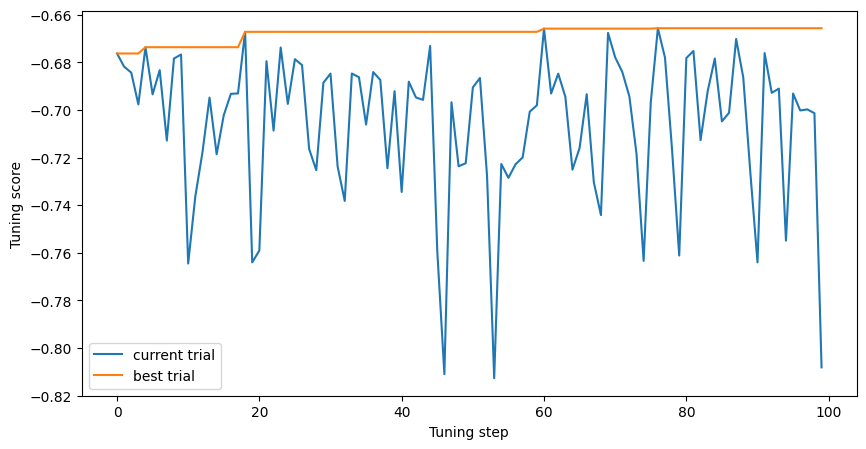

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(tuning_logs["score"], label="current trial")
plt.plot(tuning_logs["score"].cummax(), label="best trial")
plt.xlabel("Tuning step")
plt.ylabel("Tuning score")
plt.legend()
plt.show()

# Save Model

In [41]:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/distribute/save_and_load.ipynb#scrollTo=jFcuzsI94bNA
#save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
# model.save(model_gs_path,options=save_options)
# model.save(model_local_path,options=save_options)
tuned_model.save(model_gs_path)

INFO:tensorflow:Assets written to: gs://demo-tuned-tf-incident-pongthorn/tuned_binary_xgb_tf_model/assets


INFO:tensorflow:Assets written to: gs://demo-tuned-tf-incident-pongthorn/tuned_binary_xgb_tf_model/assets
